<a href="https://colab.research.google.com/github/chdhatri/Anamoly-Detection/blob/main/Model_Avg_Tip_Script_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!python --version



Python 3.10.12
/bin/bash: line 1: torch: command not found


In [1]:
import torch
print(torch.__version__)

2.1.0+cu118


In [ ]:
# prompt: check torch and torchvision version

!python -c "import torch; print(torch.__version__)"
!python -c "import torchvision; print(torchvision.__version__)"


In [2]:
!mkdir videos
!cp -r /content/drive/MyDrive/weights /content
!cp /content/drive/MyDrive/train.mp4  /content/videos
!cp /content/drive/MyDrive/test.mp4 /content/videos


cp: cannot stat '/content/drive/MyDrive/train.mp4': No such file or directory
cp: cannot stat '/content/drive/MyDrive/test.mp4': No such file or directory


In [ ]:
!cp /content/drive/MyDrive/Tip_too_low_part1.mp4 /content/videos
!cp /content/drive/MyDrive/Tip_Too_high_part1.mp4 /content/videos
!cp /content/drive/MyDrive/Tip_right_height_part1.mp4 /content/videos
!cp /content/drive/MyDrive/Tip_right_height_part2.mp4 /content/videos
!cp !cp /content/drive/MyDrive/tip_right_height_9-12-23_part1.mp4 /content/videos

cp: cannot stat '/content/drive/MyDrive/Tip_too_low_part1.mp4': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Tip_Too_high_part1.mp4': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Tip_right_height_part1.mp4': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Tip_right_height_part2.mp4': No such file or directory
cp: cannot stat '!cp': No such file or directory


In [3]:
!pip install ultralytics
!pip install scikit-learn

!pip install opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.5/644.5 kB 6.6 MB/s eta 0:00:00


In [ ]:
!mkdir -p /content/weights
!wget -P /content/weights -q https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
!wget -P /content/weights -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!ls -lh /content/weights

total 2.6G
-rw------- 1 root root  22M Oct 19 01:48 best.pt
drwx------ 2 root root 4.0K Oct 19 01:48 cylinder_weights
-rw-r--r-- 1 root root 139M Jun 20 07:01 FastSAM.pt
-rw------- 1 root root  22M Oct 19 01:48 last.pt
-rw-r--r-- 1 root root 2.4G Apr  4  2023 sam_vit_h_4b8939.pth


In [ ]:
# install FastSAM
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
!pip -q install -r FastSAM/requirements.txt
# install CLIP
!pip -q install git+https://github.com/openai/CLIP.git
# install SAM
!pip -q install git+https://github.com/facebookresearch/segment-anything.git
# install other dependencies
!pip -q install roboflow supervision jupyter_bbox_widget

Cloning into 'FastSAM'...
remote: Enumerating objects: 1171, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 1171 (delta 201), reused 186 (delta 186), pack-reused 929
Receiving objects: 100% (1171/1171), 72.45 MiB | 20.71 MiB/s, done.
Resolving deltas: 100% (456/456), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.7/611.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13

In [ ]:
!cp -r /content/drive/MyDrive/weights /content/weights
!mkdir "/content/train_images"
!mkdir "/content/train_masks"


In [6]:
import ultralytics
from ultralytics import YOLO
import cv2
import numpy as np
import os
import pandas as pd
from IPython.display import display, Image
from tqdm import tqdm
from skimage import io, color, measure, filters
import matplotlib.pyplot as plt
import time
ultralytics.checks()

import torch
#import roboflow
import base64

#import supervision as sv

#from roboflow import Roboflow
#from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

FONT = cv2.FONT_HERSHEY_SIMPLEX
POSITION = (50, 50)
FOURCC = cv2.VideoWriter_fourcc(*'XVID')



def get_mask_height(mask):

   # Find the active coordinates
    coords = np.column_stack(np.where(mask))

    # Extract bounding box coordinates
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    # Calculate the height in pixels
    height_in_pixels = y_max - y_min + 1  # "+ 1" to include both boundary pixels

    # Assume pixel spacing (resolution) is given, for example:
    pixel_spacing = 0.02  # 1/96 dpi mm/pixel

    # Convert height in pixels to height in mm
    height_in_mm = height_in_pixels * pixel_spacing

    return height_in_mm


def get_region_height(mask):
  gray = color.rgb2gray(mask)

  # Threshold the image to create a binary mask (assuming mask is brighter than the background)
  binary = gray > filters.threshold_otsu(gray)

  # Label the regions in the binary mask
  label_image = measure.label(binary)

  # Measure properties of labeled regions
  properties = measure.regionprops(label_image)

  # Assuming the mask is a single region; if not, you'd iterate through regions
  region = properties[0]

  # Height of the mask
  height = region.bbox[2] - region.bbox[0]

  # Area of the mask
  area = region.area

  return area, height


def feret_diameter(region):
    """Compute the maximum Feret diameter for a region."""
    max_diameter = 0
    coords = region.coords

    for i in range(len(coords)):
        for j in range(i+1, len(coords)):
            distance = np.linalg.norm(coords[i] - coords[j])
            if distance > max_diameter:
                max_diameter = distance

    return max_diameter

def annotate_image(image_path: str, masks: np.ndarray) -> np.ndarray:
    image = cv2.imread(image_path)

    xyxy = sv.mask_to_xyxy(masks=masks)
    detections = sv.Detections(xyxy=xyxy, mask=masks)

    mask_annotator = sv.MaskAnnotator()
    return mask_annotator.annotate(scene=image.copy(), detections=detections)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def return_mask(mask,random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    return mask_image

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))



################old logic ####################################
#######################################################
#####################################
def extract_frames(video_path, output_folder):
  cap = cv2.VideoCapture(video_path)
  # Define the codec and create VideoWriter object
  fourcc = cv2.VideoWriter_fourcc(*'XVID')
  out = cv2.VideoWriter('all_frames_output.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

  data = []
  if not cap.isOpened():
    print("Error opening video file")
    return

  fps = cap.get(cv2.CAP_PROP_FPS)
  frames_per_output = fps // 2
  frame_count = 0#start_frame
  total_time = 0
  output_count = 0
  iter = 1
  new_iter = 1
  with tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))) as pbar:
    while True:
      ret, frame = cap.read()

      if not ret:
        break

      # Define the codec and create VideoWriter object
      fourcc = cv2.VideoWriter_fourcc(*'XVID')
      out = cv2.VideoWriter('output_full.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))


      # Determine the current second in the video
      current_second = frame_count // fps

      if frame_count % frames_per_output  == 0:
        # Compute the index of the frame within the current second (0, 1, or 2)
        frame_within_second = (frame_count % fps) // (fps // 2)
        #frame label correspnds to the fps count
        frame_label = int(frame_count/fps) + 1
        #check for the rotation number
        if frame_label % 8 == 0:
            new_iter = int(frame_label/8) + 1

        file_name = f"frame_{frame_label}S_{int(frame_within_second)}F_{new_iter}I.jpg"
        output_path = f"{output_folder}/{file_name}"
        mask_path = f"{mask_folder}/{file_name}"

        #processing start time
        start_time = time.time()
        predictor.set_image(frame)

        #predict the SAM
        masks, scores, logits = predictor.predict(
          point_coords=input_point,
          point_labels=input_label,
          multimask_output=True,
          )

      for i, (mask, score) in enumerate(zip(masks, scores)):
        area = np.sum(mask.astype(bool))

        #if area < 2000:
          # Convert to numpy array for easier processing
        mask_array = np.array(mask)

          # Check rows where the mask is present
        rows_with_mask = np.any(mask_array > 0, axis=1)  # This considers any non-zero value as mask. Adjust the threshold as required.

          # Find the first and last row containing the mask
        first_row = np.where(rows_with_mask)[0][0]
        last_row = np.where(rows_with_mask)[0][-1]

          # Calculate the height
        height = (last_row - first_row + 1) * (1/96)
        text = f"Ht: {height:.2f}mm Area: {area}"
          #print("Start writting frames" )
        save_mask_on_image(frame, mask, output_path, text,out)
          #print("Frame written to:",{file_name})
        data.append([file_name, area, height])

      # Convert data to a DataFrame and then to a CSV file
      csv_file = '/content/data.csv'
      df = pd.DataFrame(data, columns=['Frame Number', 'Area', 'Height (mm)'])
      df.to_csv(csv_file, index=False)

      end_time = time.time()
      total_time += end_time - start_time

      frame_count += 1
      pbar.update(1)
      out.write(frame)
      # If frame_count is multiple of 100, print the average time
      if frame_count % 100 == 0:
        average_time = total_time / 100
        print(f"Average time for last 100 frames: {average_time:.4f} seconds")
        total_time = 0  # Reset total time for next batch of frames

  cap.release()



Ultralytics YOLOv8.0.200 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.2/225.8 GB disk)


In [ ]:
!cp /content/videos/too_high_0914_1353_part2.mp4 /content/videos

cp: cannot stat '/content/videos/too_high_0914_1353_part2.mp4': No such file or directory


In [ ]:
# prompt: unzip

!unzip /content/too_low_2023-10-03.zip

unzip:  cannot find or open /content/too_low_2023-10-03.zip, /content/too_low_2023-10-03.zip.zip or /content/too_low_2023-10-03.zip.ZIP.


In [7]:
####################################################################
##################### Refactored logic ################################
###################################################################
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
import time
import matplotlib.pyplot as plt

# Annotate the image with height information
font = cv2.FONT_HERSHEY_SIMPLEX
position = (10, 50)  # You can change this to the desired position on the image
font_scale = 2
font_color = (0, 30, 255)  # Blue color
font_thickness = 4

########## find red square bounding box in the frame ###################
def find_red_square(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    lower_red = np.array([0, 0, 200])
    upper_red = np.array([100, 100, 255])

    red_mask = cv2.inRange(frame, lower_red, upper_red)
    contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bbox = None
    for contour in contours:
        if cv2.contourArea(contour) > 500:  # filter out small contours
            x, y, w, h = cv2.boundingRect(contour)
            bbox = x, y, w, h
            #cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    return bbox


#### from the red box bbox check if the box has green color##################
def is_color_square(frame, bbox, lower_color, upper_color):
    x, y, w, h = bbox
    roi = frame[y:y+h, x:x+w]  # Extract the region of interest based on bbox
    mask = cv2.inRange(roi, lower_color, upper_color)
    return np.any(mask)  # Return True if there's any non-zero pixel in the mask

def is_green_square(frame, bbox):

    # Define lower and upper range for green color in BGR format
    lower_green = np.array([0, 100, 0])
    upper_green = np.array([50, 255, 50])

    return is_color_square(frame, bbox, lower_green, upper_green)

def is_blue_square(frame, bbox):

  # Define lower and upper range for blue  color in BGR format
  lower_blue = np.array([0, 0, 100])
  upper_blue = np.array([150, 150, 255])

  return is_color_square(frame, bbox, lower_blue, upper_blue)

def is_yellow_square(frame, bbox):

  # Define lower and upper range for yellow color in BGR format
  lower_yellow = np.array([100, 100, 0])
  upper_yellow = np.array([255, 255, 150])
  return is_color_square(frame, bbox, lower_yellow, upper_yellow)

""" Get the mask height """
def get_contour_height(img):
  # Ensure the mask is binary (0s and 255s)
  binary_mask = np.where(img > 0, 255, 0).astype(np.uint8)
   # Perform morphological operations to remove small disconnected components
  kernel = np.ones((3, 3), np.uint8)
  opening = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)


  contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  min_area_threshold = 500  # Adjust as needed
  mask_height = 0
  mask_area = 0
  for contour in contours:
      area = cv2.contourArea(contour)
      if area > min_area_threshold:
        # Calculate the height of the contour (assuming it's vertical)
        y_coords = contour[:, 0, 1]  # Get y-coordinates of the contour points
        height = (np.max(y_coords) - np.min(y_coords) + 1)  # Calculate height
        x, y, w, h = cv2.boundingRect(contour)
        contour_bbox =  x, y, w, h
        properties = measure.regionprops(contour.astype(int))
        # Get the height property (major_axis_length)
        #h = properties[0].major_axis_length
        epsilon = 0.04 * cv2.arcLength(contour, True)  # You can adjust the epsilon value as needed
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Find the convex hull of the contour
        hull = cv2.convexHull(approx)

        # Extract the vertices of the convex hull (ordered in counterclockwise manner)
        vertices = []
        for point in hull:
          x, y = point[0]
          vertices.append((x, y))

        # Sort the vertices by y-coordinate
        sorted_vertices = sorted(vertices, key=lambda point: point[1])

        # Calculate the height of the contour
        topmost_point = sorted_vertices[0]
        bottommost_point = sorted_vertices[-1]
        contour_height = bottommost_point[1] - topmost_point[1]

        height = round((h * 0.02), 2)
        width = round((w * 0.02), 2)
        print(f"Contour Area:{area}, height:{height}")
        if area > min_area_threshold:
            cv2.drawContours(binary_mask, [contour], -1, 0, -1)
            mask_height = height
            mask_width = width
            mask_area = area

  return mask_area, mask_height, mask_width, contour_bbox

def get_contour_area_height(img):
    # Ensure the mask is binary (0s and 255s)
    binary_mask = np.where(img > 0, 255, 0).astype(np.uint8)

    # Perform morphological operations to remove small disconnected components
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_area_threshold = 500  # Adjust as needed

    max_area = 0
    max_height = 0
    max_bbox = None

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area_threshold:
            # Calculate the bounding box
            x, y, w, h = cv2.boundingRect(contour)
            contour_bbox = x, y, w, h

            if area > max_area:
                max_area = area
                max_height = h  # Directly using the height of bounding box
                max_width = w
                max_bbox = contour_bbox

    if max_bbox is not None:
        return max_area, max_height, max_width, max_bbox
    else:
        return 0, 0, 0, (0, 0, 0, 0)


def getTipbbox(model, frame):
  results = model.predict(frame)
  boxes = []
  for result in results:
    boxes =result.boxes.xyxy.cpu().numpy()
    print("len:", len(boxes))
  if(len(boxes) == 0):
    print("Tip not detected")
    return None
  else:
    x1, y1, x2, y2 = map(int,boxes[0])
    return (x1, y1, x2, y2)

''' get the center of bounding box '''
def get_bbox_center(bbox):
    coords = bbox
    center_x = (coords[0] + coords[2]) / 2
    center_y = (coords[1] + (coords[3])) / 2
    return np.array([[center_x, center_y]])



""" Overlay the mask on the frames """
def save_mask_on_image(original, mask,bbox, random_color=False):

    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    color = np.array([0/255, 0/255, 128/255, 0.6])

    # Convert 3-channel mask to single channel
    # Check if mask has 3 channels
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        mask_single_channel = mask[:, :, 0]
    else:
        mask_single_channel = mask


    h, w = mask_single_channel.shape
    mask_colored = (mask_single_channel.reshape(h, w, 1) * color[:3].reshape(1, 1, -1)).astype(np.float32)
    # Find the active coordinates
    coords = np.column_stack(np.where(mask))

    # Extract bounding box coordinates for the mask
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    # Ensure original image is in float32 and range [0, 1]
    original_float = original.astype(np.float32) / 255.0

    # Combine original image with the colored mask
    combined = cv2.addWeighted(original_float, 1, mask_colored, color[3], 0)

    # Convert combined image back to range [0, 255] for saving
    combined = (combined * 255).astype(np.uint8)

    x_min = bbox[0]
    y_min = bbox[1]
    x_max = x_min + bbox[2]
    y_max = y_min +bbox[3]
    cv2.rectangle(combined, (x_min, y_min), (x_max,y_max), (255,0,0), 2)

    return combined

"""Determine if the current frame has green, blue or yellow box
  and should be processed."""
def should_process_frame(frame, bbox):
    if bbox is not None:
        if is_green_square(frame, bbox):
            return "green"
        elif is_yellow_square(frame, bbox):
            return "yellow"
        elif is_blue_square(frame, bbox):
            return "blue"
        else:
            return None
    else:
        print("No red box found on frame")
        return None

"""Process a single frame and return relevant data."""
def process_frame(color_detected,input_box, frame):
    data = []
    overlay_img = frame
    text = ""

    input_point = get_bbox_center(input_box)
    input_label = np.array([1])

    # predictor logic here
    predictor.set_image(frame)
    if color_detected != "yellow":
      prompt_box = None
    else:
      prompt_box = input_box

    masks, scores, logits = predictor.predict(
          point_coords=input_point,
          point_labels=input_label,
          box=prompt_box,
          multimask_output=False,
      )

    for i, (mask, score) in enumerate(zip(masks, scores)):
        area = np.sum(mask.astype(bool))
        print("Mask Area:", area)
        # Further processing logic
        if 500 < area < 7000:
            area, height, width, cbbox = get_contour_area_height(mask)
            height *= 0.02
            text = f"Ht: {height:.2f}mm"
            overlay_img = save_mask_on_image(frame, mask, cbbox)
            data.append([area, height])
        elif area > 7000:
          masks, scores, logits = predictor.predict(
          point_coords=input_point,
          point_labels=input_label,
          box=input_box,
          multimask_output=False,
          )
          for i, (mask, score) in enumerate(zip(masks, scores)):
            area = np.sum(mask.astype(bool))
            print("Mask Area:", area)
            # Further processing logic
            if 500 < area < 7000:
              area, height, width, cbbox = get_contour_area_height(mask)
              height *= 0.02
              text = f"Ht: {height:.2f}mm"
              overlay_img = save_mask_on_image(frame, mask, cbbox)
              data.append([area, height])

    return data, overlay_img, text


In [17]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
import numpy as np

def sam_process_frame(sam_model, input_box, frame, frame_path):
    data = []
    overlay_img = frame
    text = ""

    input_point = get_bbox_center(input_box)
    input_label = np.array([1])

    # Predictor logic here
    results = sam_model('/content/frame_2S_blue.jpg', bboxes=[875, 631, 986, 723])

    mask = results[0].masks[0].data.cpu().numpy()
    area = np.sum(mask.astype(bool))

    # Further processing logic
    if 500 < area < 7000:
        area, height, width, cbbox = get_bounding_box(mask)
        height *= 0.02
        text = f"Ht: {height:.2f}mm"
        overlay_img = save_mask_on_image(frame, mask, cbbox)
        data.append([area, height])

    return data, overlay_img, text



In [ ]:
def getFileName(fps, frame_count, color_detected):
  frame_label = int(frame_count/fps) + 1
  file_name = f"frame_{frame_label}S_{color_detected}.jpg"
  return file_name

In [ ]:
def process_and_save_frame(frame,text, out, frame_count, fps, color_detected, green_counter, image_folder, mask_folder, processed_frame):
    print("Color:", color_detected)
    if processed_frame is None:
        processed_frame = frame

    cv2.putText(processed_frame, text, POSITION, FONT, 2, (0, 0, 255), 2)
    out.write(processed_frame)

    frame_label = int(frame_count/fps) + 1
    file_name = f"frame_{frame_label}S_{color_detected}_{int(green_counter)}F.jpg"
    cv2.imwrite(os.path.join(image_folder, file_name), frame)
    cv2.imwrite(os.path.join(mask_folder, file_name), processed_frame)

    return file_name

In [8]:
moving_avg_window_size=3
moving_avg_blue_areas = []
moving_avg_blue_heights = []

moving_avg_yellow_areas = []
moving_avg_yellow_heights = []

moving_avg_green_areas = []
moving_avg_green_heights = []


def update_moving_avg(color, avg_area, avg_height, window_size):
    moving_avg_areas = None
    moving_avg_heights = None

    if color == "blue":
        moving_avg_areas = moving_avg_blue_areas
        moving_avg_heights = moving_avg_blue_heights
    elif color == "yellow":
        moving_avg_areas = moving_avg_yellow_areas
        moving_avg_heights = moving_avg_yellow_heights
    elif color == "green":
        moving_avg_areas = moving_avg_green_areas
        moving_avg_heights = moving_avg_green_heights

    moving_avg_areas.append(avg_area)
    moving_avg_heights.append(avg_height)

    if len(moving_avg_areas) >= window_size:
        moving_avg_area = sum(moving_avg_areas[-window_size:]) / window_size
        moving_avg_height = sum(moving_avg_heights[-window_size:]) / window_size
        return moving_avg_area, moving_avg_height

    return None, None


def compute_moving_avg(prev_color, color_counter, avg_area, avg_height, window_size):
    if color_counter <= 1:
        return None, None

    '''If there are fewer than 3 data points,
    compute the moving average over whatever data points are available'''
    moving_avg_area, moving_avg_height = update_moving_avg(prev_color, avg_area, avg_height, window_size)
    if moving_avg_area is None:
      moving_avg_area = avg_area
    if moving_avg_height is None:
      moving_avg_height = avg_height

    return moving_avg_area, moving_avg_height

In [10]:
def sam_avg_color_frames(model, sam_model, video_path, image_folder, mask_folder, csv_file, output_video_path):
    cap = cv2.VideoCapture(video_path)
    out = cv2.VideoWriter(output_video_path, FOURCC, 20.0, (int(cap.get(3)), int(cap.get(4))))

    all_data = []
    new_data = []
    total_time = 0
    prev_green_txt = ""
    moving_avg_text = ""
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    red_bbox = None
    color_counter = 1
    processed_frame = None
    total_metrics = np.zeros(4)
    total_area =0
    total_height = 0
    prev_color = None



    with tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))) as pbar:
        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            start_time = time.time()

            if red_bbox is None:
                red_bbox = find_red_square(frame)

            color_detected = should_process_frame(frame, red_bbox)
            if color_detected:
                tip_bbox = getTipbbox(model, frame)
                image_file_name = getFileName(fps, frame_count, color_detected)
                file_path = os.path.join(image_folder, image_file_name)
                cv2.imwrite(file_path, frame)

                if tip_bbox:
                    x1, y1, x2, y2 = tip_bbox
                    input_box = np.array([x1 , y2, x2, y2+35])
                    result = sam_process_frame(sam_model,input_box, frame, file_path)

                    if result:
                        frame_data, processed_frame, _ = result
                        # Accumulate metrics for each green frame
                        for area, height in frame_data:
                            total_area += area
                            total_height += height
                        all_data.extend(frame_data)
                        color_counter += 1
                        prev_color = color_detected
                        print(f"Processing {color_detected} frame :{prev_green_txt}")

                    else:
                        print("Warning: Couldn't process the green frame:", frame_count)
                        continue
            else:

                if color_counter > 1:
                  avg_area = total_area / (color_counter - 1)
                  avg_height = total_height / (color_counter - 1)
                  avg_text = (f"Height: {avg_height:.2f}mm  ")
                  prev_green_txt = avg_text

                  moving_avg_area, moving_avg_height = compute_moving_avg(prev_color, color_counter,
                                                                          avg_area, avg_height,
                                                                          moving_avg_window_size)
                  print("Moving Average before:",moving_avg_text)
                  moving_avg_text = "" if moving_avg_height is None else f"MA Ht: {moving_avg_height:.2f}mm"
                  print("Moving Average:",moving_avg_text)
                  file_name = process_and_save_frame(frame, avg_text+moving_avg_text, out, frame_count, fps, prev_color, color_counter, image_folder, mask_folder, processed_frame)
                  new_data.append([file_name, avg_height, avg_area, prev_color, moving_avg_height if moving_avg_height else None])
                  total_area = 0
                  total_height = 0
                  total_width = 0
                  total_diagonal = 0
                else:
                    cv2.putText(frame, prev_green_txt + moving_avg_text, position, cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
                    out.write(frame)
                color_counter = 1
                avg_text = ""
                #print("Processing red frame:", prev_green_txt)

            end_time = time.time()
            total_time += end_time - start_time
            frame_count += 1
            pbar.update(1)

            if frame_count % 100 == 0:
                print(f"Average time for last 100 frames: {total_time/100:.4f} seconds")
                total_time = 0

    df = pd.DataFrame(new_data, columns=['file_name', 'Height (mm)', 'Area', 'color', "Moving Average Height"])
    df.to_csv(csv_file, index=False)

    cap.release()
    out.release()


In [11]:
!unzip /content/drive/MyDrive/tip_2023_10_13.zip

Archive:  /content/drive/MyDrive/tip_2023_10_13.zip
  inflating: tip_2023_10_13/2023-10-13 11-44-38.mp4  
  inflating: tip_2023_10_13/2023-10-13 11-48-21.mp4  


#@Old Logic

In [ ]:

def extract_image_frames(model, video_path, image_folder, mask_folder, csv_file):
    cap = cv2.VideoCapture(video_path)
    all_data = []
    total_time = 0
    prev_green_txt = ""
    if not cap.isOpened():
        print("Error opening video file")
        return

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output_full.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    red_bbox = None
    is_frame_green = False
    green_counter = 1
    processed_frame = None

    # Define accumulators for metrics
    total_area = 0
    total_height = 0
    total_width = 0
    total_diagonal = 0

    with tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))) as pbar:
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            start_time = time.time()
            if red_bbox is None:
              red_bbox = find_red_square(frame)
            '''Process the frames for the green box '''
            if should_process_frame(frame, red_bbox):
                is_frame_green = True
                tip_bbox = getTipbbox(model, frame)
                if tip_bbox is not None:
                  x1, y1, x2, y2 = tip_bbox
                  input_box = np.array([x1 , y2, x2, y2+30])

                  result = process_frame(input_box, frame, image_folder, mask_folder, frame_count, green_counter, fps, out)
                  if result is not None:
                    frame_data, overly_frame, text = result
                    processed_frame = overly_frame

                    #Accumulate metrics for each green frame
                    for data in frame_data:
                     area, height, width, diagonal = data
                     total_area += area
                     total_height += height
                     total_width += width
                     total_diagonal += diagonal
                     print("Total height:", total_height)

                    print("Processing green frame:", prev_green_txt)
                    green_counter += 1
                    all_data.extend(frame_data)
                  else:
                    print("Warning: Couldn't process the green frame:", frame_count)
                    continue


            else:
                processed_frame = frame
                is_frame_green = False
                if green_counter >= 1:
                   avg_area = total_area / (green_counter - 1)
                   avg_height = total_height / (green_counter - 1)
                   avg_width = total_width / (green_counter - 1)
                   avg_diagonal = total_diagonal / (green_counter - 1)

                   avg_text = (f"Average area: {avg_area:.2f}  "
                                f"Height: {avg_height:.2f}mm  ")
                   # Write avg_text onto the last processed green frame
                   position = (10, 30)
                   cv2.putText(processed_frame, avg_text, position, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)


                   total_area = 0
                   total_height = 0
                   total_width = 0
                   total_diagonal = 0
                green_counter = 1
                print("Processing red frame:", prev_green_txt)

            # Write the output frame to video
            out.write(processed_frame)
            end_time = time.time()
            total_time += end_time - start_time
            frame_count += 1
            pbar.update(1)

            # If frame_count is multiple of 100, print the average time
            if frame_count % 100 == 0:
              average_time = total_time / 100
              print(f"Average time for last 100 frames: {average_time:.4f} seconds")
              total_time = 0  # Reset total time for next batch of frames


    # Convert data to a DataFrame and then to a CSV file
    df = pd.DataFrame(all_data, columns=['Frame Number', 'Area', 'Height (mm)', 'Width (mm)', 'diagonal (mm)'])
    df.to_csv(csv_file, index=False)

    cap.release()
    out.release()





In [ ]:

def new_extract_green_frames(model, video_path, image_folder, mask_folder, csv_file):
    cap = cv2.VideoCapture(video_path)
    out = cv2.VideoWriter('output_full.avi', FOURCC, 20.0, (int(cap.get(3)), int(cap.get(4))))

    all_data = []
    new_data = []
    total_time = 0
    prev_green_txt = ""
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    red_bbox = None
    green_counter = 1
    processed_frame = None
    total_metrics = np.zeros(4)
    total_area =0
    total_height = 0
    prev_color = None


    with tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))) as pbar:
        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            start_time = time.time()

            if red_bbox is None:
                red_bbox = find_red_square(frame)

            color_detected = should_process_frame(frame, red_bbox)
            if color_detected:
                tip_bbox = getTipbbox(model, frame)

                if tip_bbox:
                    x1, y1, x2, y2 = tip_bbox
                    input_box = np.array([x1 , y2, x2, y2+40])
                    result = process_frame(input_box, frame)

                    if result:
                        frame_data, processed_frame, _ = result
                        # Accumulate metrics for each green frame
                        for area, height in frame_data:
                            total_area += area
                            total_height += height
                        all_data.extend(frame_data)
                        green_counter += 1
                        prev_color = color_detected
                        print(f"Processing {color_detected} frame :{prev_green_txt}")

                    else:
                        print("Warning: Couldn't process the green frame:", frame_count)
                        continue
            else:

                if green_counter > 1:
                    avg_area = total_area / (green_counter - 1)
                    avg_height = total_height / (green_counter - 1)
                    avg_text = (f"Height: {avg_height:.2f}mm  ")
                    prev_green_txt = avg_text

                    file_name = process_and_save_frame(frame, avg_text, out, frame_count, fps, prev_color, green_counter, image_folder, mask_folder, processed_frame)
                    new_data.append([file_name, avg_height, avg_area, prev_color])

                    total_area = 0
                    total_height = 0
                    total_width = 0
                    total_diagonal = 0
                else:
                    cv2.putText(frame, prev_green_txt, position, cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
                    out.write(frame)
                green_counter = 1
                avg_text = ""
                #print("Processing red frame:", prev_green_txt)

            end_time = time.time()
            total_time += end_time - start_time
            frame_count += 1
            pbar.update(1)

            if frame_count % 100 == 0:
                print(f"Average time for last 100 frames: {total_time/100:.4f} seconds")
                total_time = 0

    df = pd.DataFrame(new_data, columns=['file_name', 'Height (mm)', 'Area', 'color'])
    df.to_csv(csv_file, index=False)

    cap.release()
    out.release()



In [ ]:
def new_extract_image_frames(model, video_path, image_folder, mask_folder, csv_file):
    cap = cv2.VideoCapture(video_path)
    all_data = []
    new_data = []
    total_time = 0
    prev_green_txt = ""
    avg_text = ""
    position = (50, 50)

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output_full.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    red_bbox = None
    is_frame_green = False
    green_counter = 1
    processed_frame = None

    total_area = 0
    total_height = 0
    total_width = 0
    total_diagonal = 0

    with tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))) as pbar:
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            start_time = time.time()

            if red_bbox is None:
                red_bbox = find_red_square(frame)

            if should_process_frame(frame, red_bbox):
                is_frame_green = True
                tip_bbox = getTipbbox(model, frame)
                if tip_bbox is not None:
                    x1, y1, x2, y2 = tip_bbox
                    input_box = np.array([x1 , y2, x2, y2+30])

                    result = process_frame(input_box, frame)
                    if result is not None:
                        frame_data, overly_frame, text = result
                        processed_frame = overly_frame

                        # Accumulate metrics for each green frame
                        for area, height, width, diagonal in frame_data:
                            total_area += area
                            total_height += height
                            total_width += width
                            total_diagonal += diagonal

                        print("Processing green frame:", prev_green_txt)
                        green_counter += 1
                        all_data.extend(frame_data)
                    else:
                        print("Warning: Couldn't process the green frame:", frame_count)
                        continue

            else:
                # Calculate average values if we've processed any green frames
                if green_counter > 1:
                    avg_area = total_area / (green_counter - 1)
                    avg_height = total_height / (green_counter - 1)
                    avg_width = total_width / (green_counter - 1)
                    avg_diagonal = total_diagonal / (green_counter - 1)

                    avg_text = (f"Height: {avg_height:.2f}mm  ")

                    # Write avg_text onto the last processed green frame
                    cv2.putText(processed_frame, avg_text, position, cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
                    out.write(processed_frame)
                    # Save the processed_frame with avg_text to the image_folder
                    frame_label = int(frame_count/fps) + 1
                    file_name = f"frame_{frame_label}S_green_{int(green_counter-1)}F_avgMetrics.jpg"  # green_counter-1 because we are considering the last green frame
                    cv2.imwrite(os.path.join(image_folder, file_name), frame)
                    cv2.imwrite(os.path.join(mask_folder, file_name), processed_frame)
                    new_data.append([file_name, avg_area, avg_height, avg_width, avg_diagonal])

                    prev_green_txt = avg_text
                    # Reset metrics for the next set of green frames
                    total_area = 0
                    total_height = 0
                    total_width = 0
                    total_diagonal = 0
                cv2.putText(frame, prev_green_txt, position, cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
                out.write(frame)
                # Resetting avg_text so that it doesn't get written to successive red frames
                avg_text = ""
                green_counter = 1
                print("Processing red frame:", prev_green_txt)


            end_time = time.time()
            total_time += end_time - start_time
            frame_count += 1
            pbar.update(1)

            if frame_count % 100 == 0:
                average_time = total_time / 100
                print(f"Average time for last 100 frames: {average_time:.4f} seconds")
                total_time = 0

    df = pd.DataFrame(new_data, columns=['file_name','Area', 'Height (mm)', 'Width (mm)', 'diagonal (mm)'])
    df.to_csv(csv_file, index=False)

    cap.release()
    out.release()


#@Run the SAM model


In [ ]:
!unzip /content/drive/MyDrive/tip_2023_10_13.zip

Archive:  /content/drive/MyDrive/tip_2023_10_13.zip
  inflating: tip_2023_10_13/2023-10-13 11-44-38.mp4  
  inflating: tip_2023_10_13/2023-10-13 11-48-21.mp4  


In [12]:
!rm -rf /content/images_1013_1148/
!rm -rf /content/masks_1013_1148/
!mkdir  /content/images_1013_1148/
!mkdir  /content/masks_1013_1148/
!rm -rf /content/results_1013_1148/
!mkdir  /content/results_1013_1148/


In [ ]:
import torch
import numpy as np
import pickle
import os
import sys
''' load the SAM model and Predictor '''

SAM_SAM_CHECKPOINT_PATH = "/content/weights/sam_vit_h_4b8939.pth"

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_SAM_CHECKPOINT_PATH).to(device=DEVICE)



In [13]:
import torch
import numpy as np
import pickle
import os
import sys

from ultralytics import SAM
sam_model = SAM('sam_b.pt')

100%|██████████| 358M/358M [00:05<00:00, 67.4MB/s]


In [ ]:
import datetime
import time
if __name__ == "__main__":
    predictor = SamPredictor(sam)


    model =  YOLO('/content/weights/cylinder_weights/best.pt')

    video_path = "/content/tip_2023_10_13/2023-10-13 11-48-21.mp4"
    image_folder = "/content/images_1013_1148"
    mask_folder = "/content/masks_1013_1148"
    csv_file = '/content/data_1013_1144.csv'
    # Capture the start time
    start_time = datetime.datetime.now()
    moving_avg_color_frames(model,video_path, image_folder, mask_folder, csv_file, "output.avi")
    #extract_frames(video_path, output_folder)
    end_time = datetime.datetime.now()

    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time}")



In [16]:
results = sam_model('/content/frame_2S_blue.jpg', bboxes = [875, 631, 986, 723])


image 1/1 /content/frame_2S_blue.jpg: 1024x1024 38050.1ms
Speed: 57.4ms preprocess, 38050.1ms inference, 35.1ms postprocess per image at shape (1, 3, 1024, 1024)


In [ ]:
!pip install ultralytics


In [ ]:
from ultralytics import SAM
sam_model1 = SAM('sam_b.pt')

100%|██████████| 358M/358M [00:01<00:00, 275MB/s]


In [14]:
results = sam_model1('/content/frame_2S_blue.jpg', bboxes=[876, 723, 995, 763])

NameError: ignored

In [ ]:
from IPython.display import display, HTML

video_name = "/content/2023-10-13_11-44-38.zip"  # Replace with your video file's name

display(HTML("""
<video width="320" height="240" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_name)))

In [ ]:
!zip -r /content/results_1013_1144_opt.zip /content/results_1013_1144_opt

#@OCR

In [ ]:
!pip install opencv-python pytesseract

In [ ]:
!apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (12.3 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 120831 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-e

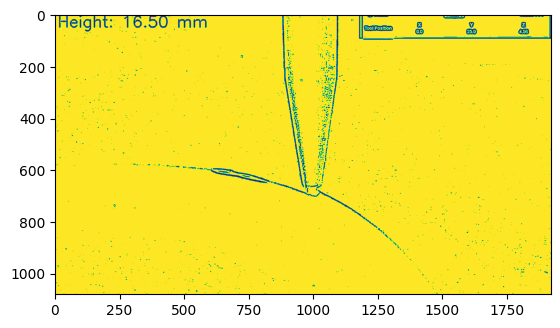

i aad ey , my os
a a — -
4 D ee.
p eee:
Pee =u re ie
: <<.) ] q ees ae
ee eves: ,
‘aes pearl’ ~ 7 : F : f
ales ii
amen a? oe”
7 2
ies .
eee
nd on. *
ete Be
: cea
— f
ae .
i. +
. aa .
See rn So
See Bs > ae
me aS ag, ae
mei Sogn
a ee. ons Ta 7 ¥
Famers a
Sg ee, Eee sek”



In [ ]:
import cv2
import pytesseract
import matplotlib.pyplot as plt

# Use pytesseract to extract text from the frame
frame = cv2.imread("/content/train_masks/frame_125S_4F_16I.jpg")
# Convert to grayscale
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gauss = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply adaptive thresholding

# Resize the frame to enlarge the text (optional, you can experiment with the factor)
#gray = cv2.resize(gray, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)

# Apply adaptive thresholding
binary = cv2.adaptiveThreshold(gauss, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

plt.imshow(binary)
plt.show()

# Perform OCR
text = pytesseract.image_to_string(gray, config='--psm 6')
print(text)

